In [ ]:
import keras
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose,LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
from tensorflow.python.keras.layers.core import Activation, Dense
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

In [ ]:
def encoder(input):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
input_shape = (64, 64, 2)
model=Sequential()

model.add(Conv2D(32,(4,4), padding='same',strides=(2,2),input_shape=input_shape))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.2))


model.add(Conv2D(64,(4,4), padding='same',strides=(2,2)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.2))


model.add(Conv2D(128,(4,4), padding='same',strides=(2,2)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.2))


model.add(Conv2D(256,(4,4), padding='same',strides=(2,2)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.2))

model.add(Conv2D(512,(4,4), padding='same',strides=(2,2)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.2))



model.add(Conv2DTranspose(256,(4,4),strides=(2,2),padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.2))

model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.2))

model.add(Conv2DTranspose(64,(4,4),strides=(2,2),padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.2))

model.add(Conv2DTranspose(32,(4,4),strides=(2,2),padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.2))

model.add(Conv2DTranspose(2,(4,4),strides=(2,2),padding='same'))




In [ ]:
model.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

In [ ]:
pdata = np.load('/content/drive/MyDrive/Samsung PRISM/processed/bonafide.npz',allow_pickle=True)
ndata = np.load('/content/drive/MyDrive/Samsung PRISM/processed/spoof.npz',allow_pickle=True)

In [ ]:
pdata['features']

In [ ]:
bonafide_features=np.concatenate(pdata['features'],axis=0)
spoof_features=np.concatenate(ndata['features'], axis=0)

In [ ]:
pdata['features'].shape

(200,)

In [ ]:
np.shape(bonafide_features)

(765, 64, 64, 2)

In [ ]:
x=[]
y=[]
features = np.concatenate(pdata["features"], axis=0)
labels = np.concatenate(pdata["labels"], axis=0)
x.extend(features)
y.extend(labels)
features = np.concatenate(ndata["features"], axis=0)
labels = np.concatenate(ndata["labels"], axis=0)
x.extend(features)
y.extend(labels)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y)
X_train=np.array(X_train)
X_test=np.array(X_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        1056      
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        32832     
_________________________________________________________________
batch_normalization_10 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 128)        

In [ ]:
np.shape(x)

(1259, 64, 64, 2)

In [ ]:
model.fit(bonafide_features,bonafide_features,batch_size=32,epochs=30,verbose=1,validation_split=0.2)

Epoch 1/30
20/20 [==============================] - 19s 904ms/step - loss: 648.3892 - accuracy: 0.3743 - val_loss: 48898.3281 - val_accuracy: 0.8908
Epoch 2/30
20/20 [==============================] - 18s 878ms/step - loss: 711.4634 - accuracy: 0.4301 - val_loss: 34104.1172 - val_accuracy: 0.8716
Epoch 3/30
20/20 [==============================] - 18s 877ms/step - loss: 552.1252 - accuracy: 0.4250 - val_loss: 18991.9355 - val_accuracy: 0.8171
Epoch 4/30
20/20 [==============================] - 18s 884ms/step - loss: 510.5612 - accuracy: 0.4458 - val_loss: 11938.6826 - val_accuracy: 0.8163
Epoch 5/30
20/20 [==============================] - 18s 883ms/step - loss: 468.2244 - accuracy: 0.4315 - val_loss: 6887.7500 - val_accuracy: 0.7031
Epoch 6/30
20/20 [==============================] - 18s 892ms/step - loss: 422.5964 - accuracy: 0.5069 - val_loss: 11938.0156 - val_accuracy: 0.7768
Epoch 7/30
20/20 [==============================] - 18s 878ms/step - loss: 376.6057 - accuracy: 0.4799 - va

In [ ]:
model.fit(bonafide_features,bonafide_features,batch_size=32,epochs=30,verbose=1,validation_split=0.2)

Epoch 1/30
20/20 [==============================] - 17s 859ms/step - loss: 8.8800 - accuracy: 0.9777 - val_loss: 25.8176 - val_accuracy: 0.9483
Epoch 2/30
20/20 [==============================] - 17s 858ms/step - loss: 9.6521 - accuracy: 0.9777 - val_loss: 25.5648 - val_accuracy: 0.9491
Epoch 3/30
20/20 [==============================] - 17s 853ms/step - loss: 7.7825 - accuracy: 0.9783 - val_loss: 28.0651 - val_accuracy: 0.9488
Epoch 4/30
20/20 [==============================] - 17s 854ms/step - loss: 7.5988 - accuracy: 0.9785 - val_loss: 27.2364 - val_accuracy: 0.9488
Epoch 5/30
20/20 [==============================] - 17s 856ms/step - loss: 7.6372 - accuracy: 0.9785 - val_loss: 25.4379 - val_accuracy: 0.9491
Epoch 6/30
20/20 [==============================] - 17s 854ms/step - loss: 7.8169 - accuracy: 0.9787 - val_loss: 25.6181 - val_accuracy: 0.9487
Epoch 7/30
20/20 [==============================] - 17s 854ms/step - loss: 8.0964 - accuracy: 0.9787 - val_loss: 25.7125 - val_accuracy:

In [ ]:
model.save('/content/drive/MyDrive/Samsung PRISM/model.h5')

In [ ]:
model=keras.models.load_model('/content/drive/MyDrive/Samsung PRISM/model.h5')

In [ ]:
y_test=np.reshape(y_test, (-1, 1))
y_test=y_test[:,0]

In [ ]:
X_test

NameError: ignored

In [ ]:
valid_x_predictions = model.predict(X_test)
mse=[]
for i in range(len(X_test)):
  mse.append(np.mean((X_test[i]-valid_x_predictions[i])**2))
  #mse.append(np.linalg.norm(np.ravel(X_test[i])-np.ravel(valid_x_predictions[i])))
  #error_df = pd.DataFrame({'Reconstruction_error':mse[i],'True_class':y_test[i]})

In [ ]:
mse

[4.961312943659171,
 4.13468546283893,
 1.7302751914901235,
 7.160579624121658,
 7.6248070117362,
 6.554367049738162,
 7.00630917991392,
 8.3783157969185,
 8.052326666774174,
 5.15046423351598,
 19.219353779773837,
 33.314384707882624,
 23.516730730827106,
 3.78566134643986,
 31.28432260330638,
 26.23462517972886,
 5.0438342619553485,
 27.065461645034304,
 34.850038992329566,
 30.648190147754907,
 38.453403029015575,
 9.120220024311841,
 27.63631270387804,
 27.968034914843734,
 34.579336105378275,
 23.166289608716625,
 3.5871350427622106,
 43.94953579081235,
 8.899188226548283,
 29.3013015102423,
 19.18328544944599,
 30.48573891665388,
 35.24174315668064,
 2.6793672480494495,
 17.14031770553355,
 6.167272279097038,
 5.800398353066465,
 21.36057809189726,
 34.75836946917573,
 30.799566037229148,
 8.28518706238189,
 4.709060680696896,
 32.34274927054401,
 19.890025942185908,
 20.742216115277643,
 25.645744375884874,
 35.24671986830779,
 2.202965596239384,
 41.38211379113227,
 5.166847690

In [ ]:
error_df.head(5)

,Reconstruction_error,True_class
0,244.603614,1


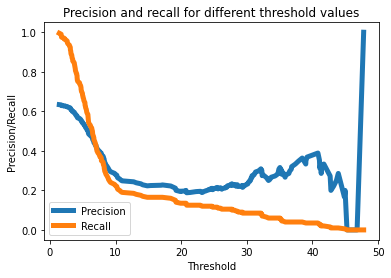

In [ ]:
#valid_x_predictions = model.predict(X_test)
#mse = np.mean(np.power(np.ravel(X_test)[0] - np.ravel(valid_x_predictions)[0], 2), axis=1)
#error_df = pd.DataFrame({'Reconstruction_error': mse,
 #                       'True_class': y_test})
#precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
precision_rt, recall_rt, threshold_rt = precision_recall_curve(y_test,mse)

plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [ ]:
test_x_predictions = model.predict(X_test)
d=pd.DataFrame()
error_df=pd.DataFrame(columns=('Reconstruction_error','True_class'))
mse=[]
for i in range(len(X_test)):
  mse.append(np.linalg.norm(np.ravel(X_test[i])-np.ravel(test_x_predictions[i])))
  d=pd.DataFrame({'Reconstruction_error':mse[i],'True_class':y_test[i]})
  error_df=error_df.append(d)
  #error_df.append(d,ignore_index = True)

ValueError: ignored

In [ ]:
pd.DataFrame(columns=('Reconstruction_error','True_class'))

,Reconstruction_error,True_class


In [ ]:
d=pd.DataFrame({'Reconstruction_error':mse[0],'True_class':y_test[0]})

In [ ]:
error_df=error_df.append(d)

In [ ]:
error_df

,Reconstruction_error,True_class
0,295.006806,1
0,510.625705,0
0,245.312703,1
0,279.419361,1
0,232.709333,1
...,...,...
0,450.893534,0
0,395.660075,0
0,403.392396,0
0,453.658454,0


In [ ]:
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                       'True_class': df_test['y']})

NameError: ignored

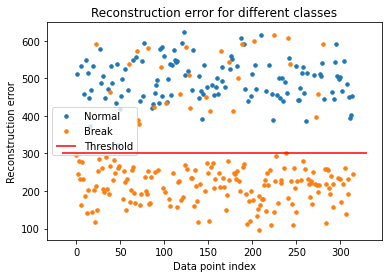

In [ ]:
#test_x_predictions = model.predict(df_test_x_rescaled)
#mse = np.mean(np.power(df_test_x_rescaled - test_x_predictions, 2), axis=1)
#error_df_test = pd.DataFrame({'Reconstruction_error': mse,
#                       'True_class': df_test['y']})
error_df_test=error_df
error_df_test = error_df_test.reset_index()
threshold_fixed = 300
groups = error_df_test.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [ ]:
np.shape(pred_y)

(315,)

In [ ]:
np.shape(error_df.True_class)

(315,)

In [ ]:
import seaborn as sns
LABELS = ["Normal","Break"]
threshold_fixed = 400


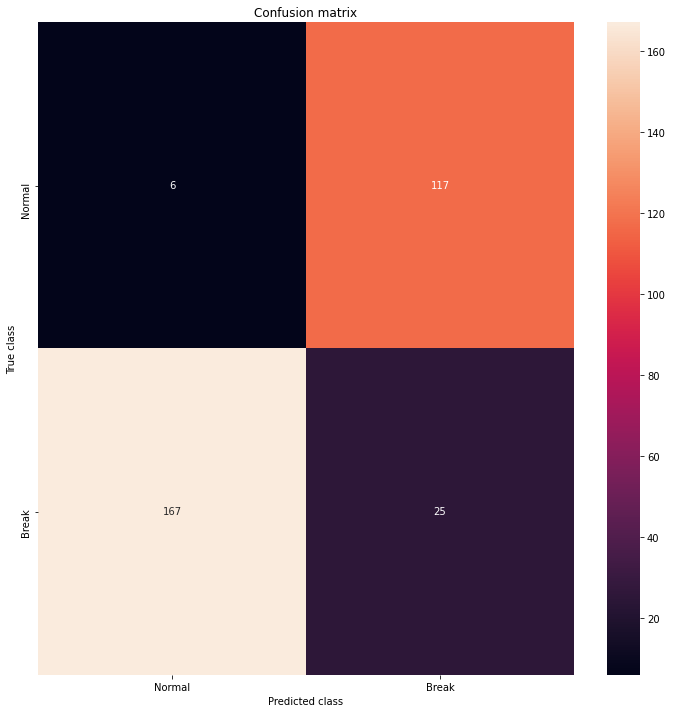

In [ ]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(y_test, pred_y)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
recall_rt

array([1., 0.])

In [ ]:
valid_x_predictions.shape

(315, 64, 64, 2)

In [ ]:
np.ravel(mse).shape


()

In [ ]:
b

array([  5.26991288,   6.99663651,   5.5367849 ,   3.10879926,
         5.71185492,   8.3051792 ,   8.61350157,   4.19098598,
         5.19623973,   6.60498327,   7.0015103 ,   3.71967934,
         3.65835822,   5.22213159,   5.55424577,   4.32676695,
         5.13284321,   5.41739564,   4.46351295,   4.43156241,
         5.12730954,   4.60843622,   4.54772409,   4.39354304,
         4.64252886,   4.18309317,   3.19232584,   3.70953479,
         5.69800051,   8.1403541 ,   5.85088648,   4.5341339 ,
         5.09590774,   5.52888423,   4.26242013,   6.00821095,
         7.50921544,   4.22066733,   5.07426355,   7.27871581,
         6.51618681,   6.48801127,   6.05677418,   6.49964393,
         7.68079905,   9.07712127,   9.93016949,   7.79051973,
         7.64432217,   9.16886333,   9.95055573,   9.48887855,
         8.38818972,   9.67952611,  12.80610571,  17.09397124,
        16.32394251,  42.25341007,  90.68768148, 119.35997467,
       133.2843335 , 127.54011082, 119.41487384, 107.71

In [ ]:
np.linalg.norm(np.ravel(X_test[10])-np.ravel(valid_x_predictions[10]))

185.33771905694005

In [ ]:
b.shape

(64,)

In [ ]:
b=np.linalg.norm(np.ravel(X_test)-valid_x_predictions[0],axis=(1,2))

In [ ]:
y_test=np.reshape(y_test, (-1, 1))


In [ ]:
y_test.shape

(315, 1)

In [ ]:
y_test=y_test[:,0]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y)
X_train=np.array(X_train)
X_test=np.array(X_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

In [ ]:
model.fit(X_train,X_train,batch_size=32,epochs=50,verbose=1,validation_data=(X_test,X_test))

Epoch 1/50
30/30 [==============================] - 29s 980ms/step - loss: 17.7086 - accuracy: 0.9614 - val_loss: 22.5351 - val_accuracy: 0.9539
Epoch 2/50
30/30 [==============================] - 30s 1000ms/step - loss: 17.9981 - accuracy: 0.9617 - val_loss: 20.5591 - val_accuracy: 0.9548
Epoch 3/50
30/30 [==============================] - 30s 997ms/step - loss: 15.4536 - accuracy: 0.9635 - val_loss: 22.9504 - val_accuracy: 0.9551
Epoch 4/50
30/30 [==============================] - 30s 1s/step - loss: 15.2738 - accuracy: 0.9635 - val_loss: 19.6978 - val_accuracy: 0.9542
Epoch 5/50
30/30 [==============================] - 30s 996ms/step - loss: 15.8853 - accuracy: 0.9639 - val_loss: 20.4316 - val_accuracy: 0.9544
Epoch 6/50
30/30 [==============================] - 30s 991ms/step - loss: 15.7581 - accuracy: 0.9637 - val_loss: 23.8783 - val_accuracy: 0.9546
Epoch 7/50
30/30 [==============================] - 30s 992ms/step - loss: 17.5221 - accuracy: 0.9633 - val_loss: 22.8657 - val_accu

In [ ]:
np.shape(X_train)

(1740, 60, 41, 2)

In [ ]:
np.expand_dims(bonafide_features[0],axis=0).shape

(1, 64, 64, 2)

In [ ]:
x=model.predict(np.expand_dims(bonafide_features[0],axis=0))

In [ ]:
x.shape

(1, 64, 64, 2)

In [ ]:
model.eval()

In [ ]:
import numpy as np

In [ ]:
a=np.random.random(size=(30,30,3))
b=np.random.random(size=(30,30,3))

In [ ]:
x=np.mean((a-b)**2)

In [ ]:
x

0.1629940217186788

In [ ]:
images=X_train
decoded=model.predict(images)

In [ ]:
errors = []
for (image, recon) in zip(images, decoded):
	# compute the mean squared error between the ground-truth image
	# and the reconstructed image, then add it to our list of errors
	mse = np.mean((image - recon) ** 2)
	errors.append(mse)

In [ ]:
errors

In [ ]:
thresh = np.quantile(errors,0.8)
thresh=45

In [ ]:

idxs = np.where(np.array(errors) >= thresh)[0]
print("[INFO] mse threshold: {}".format(thresh))
print("[INFO] {} outliers found".format(len(idxs)))

[INFO] mse threshold: 45
[INFO] 17 outliers found


In [ ]:
id=np.where(np.array(y_test)==1)

In [ ]:
np.shape(id)

(1, 200)

In [ ]:
id==idxs

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


False

In [ ]:
id

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  13,
         16,  21,  25,  26,  28,  30,  33,  35,  36,  40,  41,  42,  43,
         47,  49,  51,  52,  53,  54,  55,  57,  59,  61,  62,  65,  66,
         68,  69,  71,  73,  75,  77,  79,  80,  82,  83,  84,  86,  87,
         88,  89,  90,  91,  92,  93,  94,  98,  99, 100, 103, 104, 106,
        108, 109, 110, 111, 114, 115, 116, 117, 119, 120, 121, 122, 123,
        124, 125, 126, 127, 128, 129, 131, 134, 137, 138, 139, 140, 143,
        144, 145, 146, 147, 148, 149, 150, 151, 152, 154, 155, 156, 157,
        158, 160, 165, 167, 168, 169, 172, 174, 176, 177, 179, 180, 183,
        184, 186, 187, 189, 190, 191, 192, 193, 196, 197, 199, 201, 203,
        206, 207, 209, 211, 213, 214, 215, 216, 219, 220, 221, 222, 224,
        225, 227, 228, 231, 232, 233, 236, 237, 238, 239, 241, 242, 243,
        245, 247, 248, 250, 252, 253, 254, 259, 260, 261, 262, 263, 266,
        267, 268, 269, 270, 271, 272, 274, 275, 276

In [ ]:
idxs

array([  0,   1,   6,   7,  12,  14,  19,  21,  30,  36,  40,  46,  51,
        62,  63,  66,  73,  79,  84,  93, 106, 111, 114, 119, 125, 126,
       133, 142, 169, 172, 175, 185, 189, 190, 192, 206, 219, 225, 245,
       256, 269, 274, 278, 279, 285, 288, 289, 292, 303, 305, 324, 326,
       328, 331, 339, 342, 344, 349, 360, 364, 372, 375, 377, 380, 381,
       384, 389, 394, 405, 407, 414, 415, 417, 418, 423, 435, 444, 447,
       450, 453, 456, 457, 459, 472, 477, 479, 481, 482, 483, 490, 495,
       498, 501, 503, 504, 506, 508, 515, 516, 518, 524, 533, 534, 537,
       542, 548, 557, 558, 560, 564, 565, 568, 570, 575, 576, 579, 585,
       587, 600, 618, 620, 625, 627, 628, 629, 631, 632, 634, 642, 644,
       652, 654, 657, 661, 666, 668, 679, 680, 681, 682, 683, 685, 686,
       689, 692, 693, 696, 702, 727, 733, 734, 739, 743, 745, 747, 749,
       755, 761, 762, 763, 769, 773, 775, 778, 783, 790, 791, 797, 799,
       823, 833, 835, 836, 837, 849, 858, 865, 866, 871, 873, 88